In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
epsilons = [0.2, 0.15, 0.1, 0.05]

def epsilon_to_num_samples(num_consumers, num_goods, epsilon, delta, c, excluded_pairs):
    ser = np.ceil(np.log((2.0 * num_consumers * num_goods - len(excluded_pairs)) / delta) * 0.5 * (c / epsilon) * (c / epsilon)) * num_consumers * num_goods
    ser = ser.astype('int64')
    return ser

def add_ea_num_samples(data, eps_col_name):
    data['ea_num_samples'] = epsilon_to_num_samples(data['num_consumers'], 
                                             data['num_goods'], 
                                             data[eps_col_name], 
                                             0.1, 
                                             data['noise_factor'] + 10.0, 
                                             set())
def add_savings_col(data):
    add_ea_num_samples(data, 'final_epsilon')
    data['savings'] = (1.0 - (data['total_num_samples'] / data['ea_num_samples'])) * 100.0
    return data

def select_data(data, selectors):
    res = data
    for col, val in selectors.items():
        if val is not None:
            res = res[res[col] == val]
    return res

def get_stats(data):
    return data['savings'].mean()

def get_summary(x, type_of_market = None, target_eps = None):
    result = []
    for num_c in [5, 10, 15, 20]:
        res = []
        for num_g in [5, 10, 15, 20]:
            res += [get_stats(select_data(x, {'type_market' : type_of_market, 
                                              'num_consumers' : num_c, 
                                              'num_goods': num_g,
                                              'target_eps': target_eps,
                                              #'noise_factor': 1.0
                                             }))]
        result += [res]
    return np.array(result)

In [3]:
results_dir = '../results/'
data = pd.concat([pd.read_csv(f'{results_dir}results_eap_{source}.csv') for source in ['enrique', 'karina', 'grid']])
data = add_savings_col(data)
x = data.groupby(['num_consumers', 'num_goods', 'type_market', 'noise_factor', 'target_eps']).mean().reset_index()
data.columns

Index(['num_consumers', 'num_goods', 'type_market', 'noise_factor',
       'target_eps', 'final_epsilon', 'total_num_samples', 'total_pruned_0',
       'total_pruned_1', 'total_pruned_2', 'ea_num_samples', 'savings'],
      dtype='object')

[[ 12.69087003  23.42272098  30.39693316  32.36119591]
 [-20.04075674  -4.56574668  -8.09390946  -9.81745362]
 [-55.40528254 -52.00162512 -38.18606838 -43.80589123]
 [-89.62354926 -84.5711935  -81.41515415 -67.29969258]]


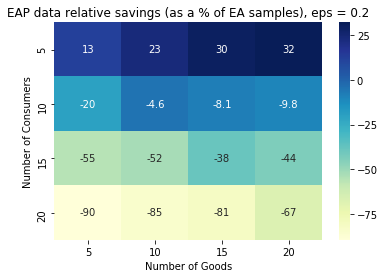

In [4]:
eps = 0.2
data = get_summary(x, target_eps=eps)
print(data)
ax = sns.heatmap(data, 
                 annot=True, 
                 cmap="YlGnBu", 
                 xticklabels=[i for i in [5, 10, 15, 20]],
                 yticklabels=[j for j in [5, 10, 15, 20]])
ax.set_xlabel('Number of Goods')
ax.set_ylabel('Number of Consumers')
ax.set_title(f'EAP data relative savings (as a % of EA samples), eps = {eps}')
plt.savefig(f'/Users/enriqueareyan/Documents/workspace/noisyce/plots/eap_savings_eps_{eps}.png', 
           figsize=(1, 1), dpi=150)